In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# learning about gradients and activations

will help us understand network training

RNNs are "universal approximators" can in theory model any algorithm but in reality they are difficult to train using our first order gradient techniques

To understand this we need to understand gradients and activations

Most model improvements on RNNs (GRU and LSTM) seek to address these issues


# code from last time

In [2]:
# read in all the wrods
words = open("makemore/names.txt", "r").read().splitlines()
len(words)

32033

In [3]:
#build the vocabulary of characters and ampping tofrom integers
chars = sorted(list(set("".join(words))))
stoi = {s:i for i,s in enumerate(["."] +chars)}
itos = {i:s for s,i in stoi.items()}
vocab_size = len(stoi.items())


In [4]:
#build the dataset
# build the dataset
def build_dataset(words):
    block_size = 3 # how many chars do we take to predict the next one (context length)
    X, Y = [], []

    for w in words[:]:
        #print(w)
        context = [0]*block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print("".join(itos[i] for i in context),"-->",itos[ix])
            context = context[1:] + [ix] #crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    X.shape, Y.shape
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])



In [30]:
#MLP revisited
n_emb = 10 #dimensionality of character embedding vectors
n_hidden = 200 #number of neurons in hidden layer
block_size = 3

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb),                    generator = g) 
W1 = torch.randn((n_emb * block_size, n_hidden),        generator = g) * (5/3) / ((n_emb*block_size)**0.5) #kaiming init with tanh correction
#b1 = torch.randn(n_hidden,                              generator = g) * 0.01 #normalization makes this bias useless
W2 = torch.randn((n_hidden,vocab_size),                 generator = g) * 1 / (n_hidden**0.5) #?not sure about gain of softmax
b2 = torch.randn(vocab_size,                            generator = g) * 0

bngain = torch.ones((1,n_hidden)) #1 for each neuron (over the whole batch oth dimension is just 1)
bnbias = torch.zeros((1,n_hidden))

bnmean_running = torch.zeros((1, n_hidden)) #updated on side of gradient
bnstd_running = torch.ones((1,n_hidden))

parameters = [C,W1,b1,W2,b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


In [31]:
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):

    #minibatch construction
    ix = torch.randint(0,Xtr.shape[0],(batch_size,)) #?with replacement
    Xb , Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb] #X is indexed to select minbatch
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 #+ b1 normalizaiton makes bias useless - instead handles by batch normalization bias

    # BatchNorm layer --------------------------------------------------------------------
    # we want to make hpreact roughly gaussian
    #need to take mean across 0th dimension - we want across hte batch rather than across the layer (mean of samples, rather than mean of neurons)
    #keep dim true to allow us to braodcast will have shape (1,n_hidden) while hpreact has (batch_size,n_hidden) so will be copied across oth dimension
    #hpreact = (hpreact - hpreact.mean(0,keepdim = True))/(hpreact.var(0,keepdim = True)**0.5)
    bnmeani = hpreact.mean(0,keepdim = True)
    bnstdi = hpreact.var(0,keepdim = True)**0.5
    hpreact = bngain * (hpreact - bnmeani)/(bnstdi) + bnbias
    #but this will screw up training - we only want them to be gaussian at initialization
    
    with torch.no_grad(): #stops pytorch from building up the graph
        #not updated through gradient descent
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
        #this is how it is implemented in pytorch
    # -------------------------------------------------------------------

    #Non - linearity
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    learning_rate = 0.1 if i < max_steps / 2 else 0.01 #simple elarning rate decay
    for p in parameters:
        p.data -= learning_rate * p.grad

    #track stats
    lossi.append(loss.log10().item())
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")

    #making an image
    for j in [100,1000,2000,3000,4000,5000,6000,7000,8000,9000] + list(np.arange(10000,max_steps,10000)):
        if i == j:
            fig, ax = plt.subplots()
            fig.set_size_inches(8,8)
            ax.scatter(C[:,0].data,C[:,1].data,s = 200)
            for ch_ind in range(C.shape[0]):
                ax.text(C[ch_ind,0].item(), C[ch_ind,1].item(), itos[ch_ind], ha = "center", va = "center", color = "white")
            ax.grid("minor")
            ax.set_title(f"epoch {i}")
            fig.savefig(f"plots/epoch_{i}.png")
            plt.close() #close plots to stop them living in memory


# this works right now as we are just overfitting 32 examples
#Karpathy says do this everytime you train a netwrok - overfit a single batch to check everything is working well

#loss cant get to 0 as there are some duplicate inputs with different outputs


      0/ 200000: 3.8000
  10000/ 200000: 2.5099
  20000/ 200000: 2.1790
  30000/ 200000: 1.9812
  40000/ 200000: 2.2750
  50000/ 200000: 2.2108
  60000/ 200000: 2.6499
  70000/ 200000: 2.5225
  80000/ 200000: 2.5703
  90000/ 200000: 2.1523
 100000/ 200000: 2.2744
 110000/ 200000: 2.1545
 120000/ 200000: 1.8504
 130000/ 200000: 2.0913
 140000/ 200000: 1.7282
 150000/ 200000: 2.2403
 160000/ 200000: 2.1900
 170000/ 200000: 1.9810
 180000/ 200000: 2.5112
 190000/ 200000: 2.0887


In [24]:
# calibrate hte batchnorm at the end of training

# with torch.no_grad(): #just improve efficiency
#     # pass the training set through
#     emb = C[Xtr]
#     embcat = emb.view(emb.shape[0],-1)
#     hpreact = embcat @ W1 + b1#measure the meana dn std over the entrie traiing set
#     bnmean = hpreact.mean(0,keepdim = True) #these are now fixed numebrs -
#     bnstd = hpreact.std(0, keepdim = True)


#people are lazy - so instead of doing it like this you learn it while training the network - see above - to not have 2 different training steps

In [33]:
@torch.no_grad() #thie decorator disables gradient tracking 
#decorator sits ontop of a function and affects that fnuction
# .no_grad() means torch will not track any gradients of this forward pass
# all tensors have .require_grad = False
# ? Context manager
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte,Yte),
    }[split]
    emb = C[x] #(N, block_size, n_embd)
    embcat = emb.view(emb.shape[0],-1) # concat onto (N, block_size * n_emb)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running)/(bnstd_running) + bnbias #batch normalization, with the fixed bnmean and bnstd - now we can forward a single example
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split,loss.item())

split_loss("train")
split_loss("test")


train 2.0679397583007812
test 2.1098477840423584


# misc experimental code and plotting

In [8]:
import imageio

In [34]:
# create GIF
#creating plot
with imageio.get_writer("test2.gif",mode = "i") as writer: #get_writer creates a new file "line.gif" and mode simply tells it we are giving it images as an input
    for i in [100,1000,2000,3000,4000,5000,6000,7000,8000,9000] + list(np.arange(10000,max_steps,10000)):
        image = imageio.v2.imread(f"plots/epoch_{i}.png"); #read image
        writer.append_data(image) #writes to the file specified above

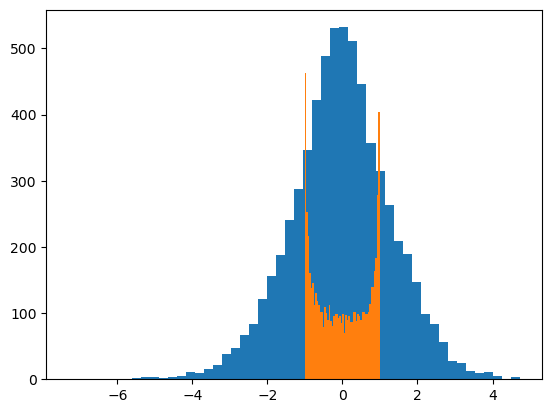

In [35]:
# # check tanh values after initialization
plt.hist(hpreact.view(-1).tolist(),bins = 50); #semi colon suppreses text
plt.hist(h.view(-1).tolist(),bins = 50); #semi colon suppreses text

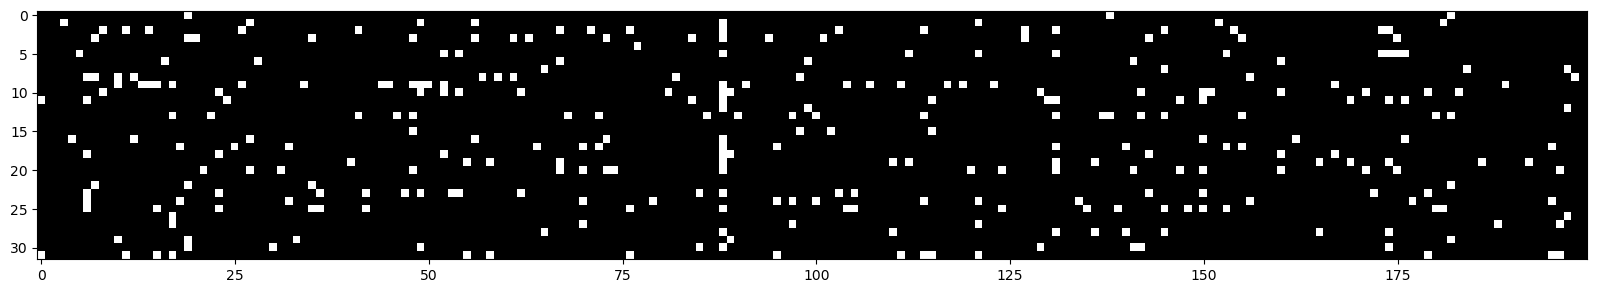

In [36]:
plt.figure(figsize = (20,10))
plt.imshow(h.abs() > 0.99, cmap = "gray",interpolation = "nearest")
#if white = in a flat region
# if for one of these neurons every column is white - this is called a dead neuron
# neuron is not sensitive to any of hte inputs -all enurons go to 0
# will be stuck

In [12]:
#{"test":[1,2,3]}["test"]

In [13]:
#sample from modle
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size #initialize
    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view(emb.shape[0],-1) # concat onto (N, block_size * n_emb)
        h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
        logits = h @ W2 + b2 # (N, vocab_size)
        counts = logits.exp()
        prob = F.softmax(logits, dim = 1) 
        ix = torch.multinomial(prob, num_samples = 1, generator = g).item()

        #shift context windown
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break

    print("".join(itos[i] for i in out))

brbabgghanzshevfedhny.
luqmivrslejghnngtodcepprellizslipselleksisssopparlellbcottalpin.
shdwnngxhdminstyn.
joxtdviqxettalfius.
kaddi.
kyldslyehs.
klajndsklyah.
hbldsadyansuftzgahliqubrdtchmpksvikostzpsh.
brftyxoeshangphir.
sumtez.
shhmeernnisssorgelverdwvllanictarvizthphrshlvislitgfedvallivid.
mellaketbuklypxanntud.
jshiv.
kgyannclaudrifwandillvislquijahnnahmniftlfptta.
kimbegloveetgannnbek.
klporyinstzvabrrtzw.
shkmambertbncarldvettw.
francellamryzdelbeel.
fclylbs.
bbightanqusfarrllluxpdngtoportco.


# fixing up this old code
# 1. Initialization 
- if predicting uniform 1/27 change of being right so loss will be 
-log(1/27) =~ 3.3, however our starting loss is 27! - becuase we initialize with normal dist centered on 0
?Network is very confidently wrong occasionally - makes softamx have very low prob for the real answer
- more extreme values for logits - higer loss (as unlikely by chance to assign the highest prob to the true value, more likely that high value is for another output and this squashes the prob of the true value when doing softmax)
We want initial output to be a uniform probability distribution

### so how to we make logits closer to 0 - ideal becuase of symmetry (rather than all being 1)
a. Initialize bias as 0 
b. scalle weights lower - **BUT NOT 0**
    Need loss to have some entropy - used for symmetry breaking

lose hockey stick appearance of loss


# 2. Activation of hidden states (Saturated tanh)

Initial activation of hidden layer - lots of -1's and 1's

We have tanhed - this region of hte tanh is very flat - we are on the tail
 - so gradients will be small 
Will "kill" the backprogogation through this neuron, will take very small steps
Remember "Gradient" descent - gradient vanishe

dtanh/dx = 1 - tanh**2 

For tanh when output = 0, grad = 1 so backprob gradient just flows through, so the more away from 0 you are the less hte graient will flow

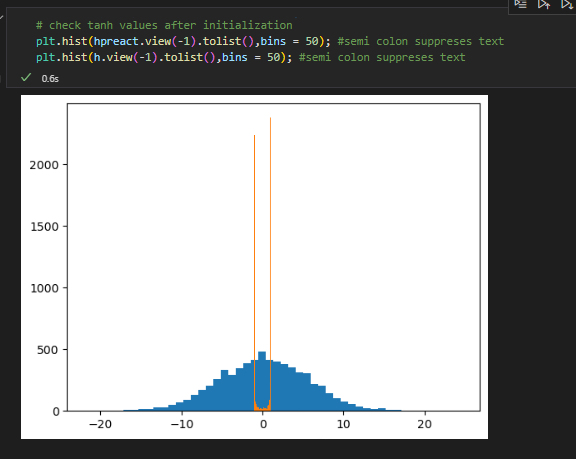

all squashing activation functions will have this issue
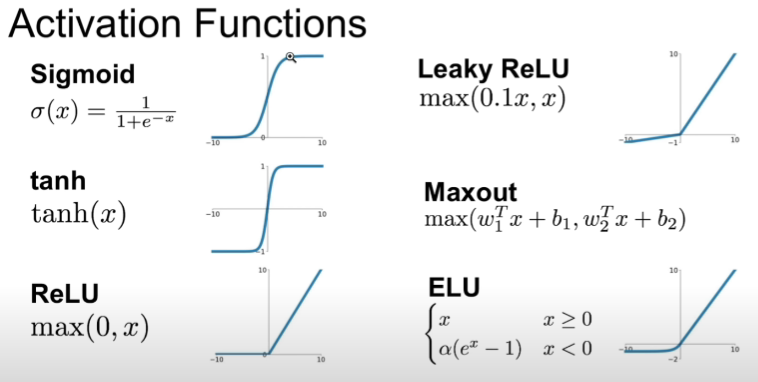

ReLU is dead below 0 - can start dead or if your learning rate is too high it can jump into the dead region ("knocked out of the data manifold")
    *Note that over hte course of training, neurons will naturally become saturated

Like brain damage in the neural network

*tip is that your fully train a ReLU network then you forward pass to find a dead neurons

Leaky ReLU is designed to cope with this issue 


Easiest way to cope with this - shrink the param 

This is easy for a smal l netwrok
But these problems stack so can be a real issue for larger networks.

# BUT HOW DO WE FIND A GOOD INITIALIZATION







tensor(-0.0072) tensor(0.9984)
tensor(0.0035) tensor(1.0003)


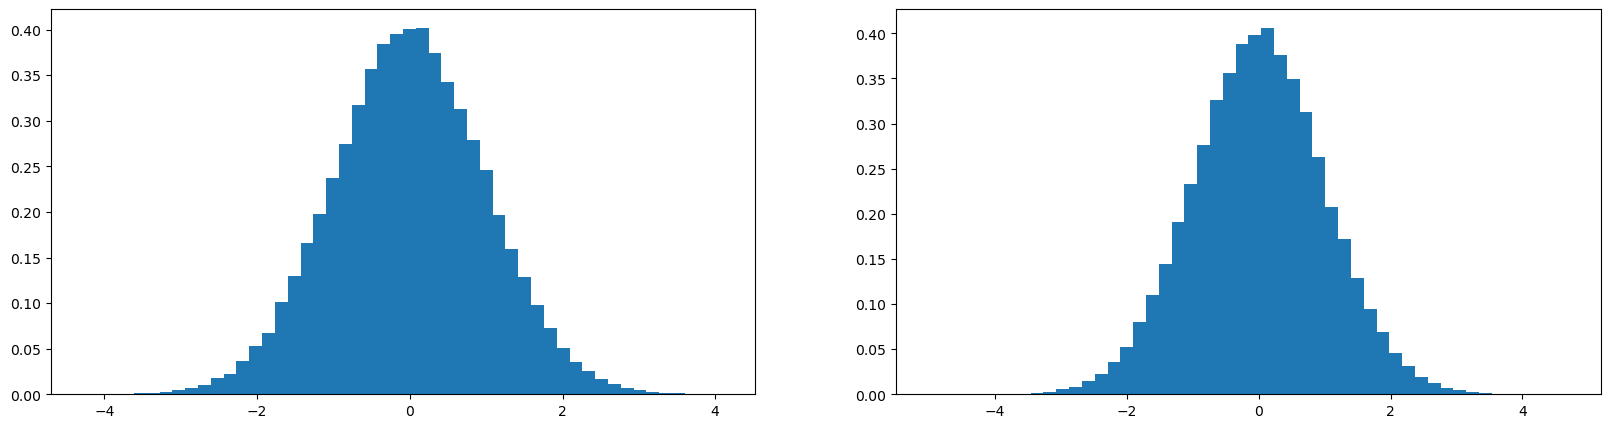

In [14]:
# some prefacing explanation on variance changes after matrix multiplication of gausians

#mean stays the same as it is a symmetric operation
#however standard deviation has increased

#we dont want this
# we ant uint gaussian throughtout the neural net

#how do we scale this?
#what number do we scale w by to make y have a unit standard 

#try matrix of size 10,100 and 1000 
n = 100
x = torch.randn(1000,n)
w = torch.randn(n,100) / n**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize = (20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50,density = True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50,density= True);

x = unit_normal
E[x] = 0
Variance = 1 = E[x**2] - E[x]**2
Variance = 1 so E[x**2] = 1

w = unit_normal

if independent 
E[xy] = E[x]*E[y]

Var[xy] = E[x**2 * y **2] - E[xy]**2
Var[xy] = E[x**2] * E[y**2] = 1

BUT WHEN MATRIX MULTIPLYING THIS DOESNT HOLD.... as we also have addition from the dot product

$
E[x + y] = E[x] + E[y] = 0 + 0 = 0 \\
Var[x + y] = E[x**2 + 2xy + y**2] - E[x + y]**2 \\
Var[x + y] = E[x**2] + 2E[xy] + E[y**2] - 0
Var[x + y] = 1 + 2(E[x]*E[y]) + 1
Var[x + y] = 1 + 2*0 + 1 = 2
$

Var scaled linearly with number of units so std scales sqrt

so need to scale matrix by....

# $ \dfrac{1}{\sqrt{n}} $

# where n = "fanin"

# but ReLU squashes away half of the code so need to compensate for this with doublign the gain to get 

# $ \dfrac{2}{\sqrt{n}} $

can do this in pytorch

# torch.nn.init.kaiming_normal_()

karpathy just goes 1/sqrt(n)

In [15]:
x = np.random.normal(0,1,1000)
w = np.random.normal(0,1,1000)
print(f"x, mean:{x.mean():.4f} w, mean: {w.mean():.4f}")
print(f"x*y mean:{(x*w).mean()} var:{(x*w).var()}")
print(f"x + y mean:{(x+w).mean()} var:{(x+w).var()}")


x, mean:-0.0046 w, mean: -0.0273
x*y mean:0.015024171569376342 var:0.8875741201763758
x + y mean:-0.03192193138255582 var:1.9916558249447103


# **Batch normalization**

We want preactivation states to be roughly unit gaussian at initialization

### So why not just normalize them to be gaussian

standardizing hiddens states is a perfectly differentiable operation :)

So do batch normalization

But we dont want them to stay standard normal 

# tested this and loss was a 3.5 for train and test - sike i made an error - loss is fine across this small netwrok but would make a difference in larger networks

so can just add scale and shift terms which the network can learn

Interesting

Basically impossible to tune scales so that all activations are roughlly gasussian 

So we sprinkle batch normalization layers throughout the NN

## **Batch noramlization after every linear layer - wowowwow**

Significantly stabilizes trainig

# But comes at a terrible cose

Previously...

single input feeds into a neural net which creates activations and finally its logits and this is deterministic process

Batches introduced for efficiency

But now Batches influence the forward pass of each input
## So now the activations are a function of all the other inputs in the batch

# ##BLACK MAGIC##

THIS IS ACTUALLY GOOD - acts as a regularizer - inputs entropy

a form of data augmentation

Makes it harder to neural net to ovefit the examples

# No-one likes this property to prevent coupling so people have tried to depricate this

Alternatives:
1. Linear 
2. Instance
3. Group


How do we sample from a NN with normalized layers??

